# MLFA Lab Assignment: Feedforward Neural Network & CNN Model


In [ ]:
#Salil Lokhande
#21ME10067

In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [4]:
!pip install torchprofile

# Question 1
**Loading the dataset**

In [5]:
from google.colab import drive
drive.mount('/content/drive')  # Mount your Google Drive
import numpy as np
import torch
import torchmetrics
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Load the npz file
data_path = '/content/drive/MyDrive/Datasets/imbalanced_mnist (1).npz'
npz_file = np.load(data_path)

# Extract numpy arrays from the npz file
X_train_np = npz_file['X_train']
y_train_np = npz_file['y_train']
X_test_np = npz_file['X_test']
y_test_np = npz_file['y_test']

print(X_train_np.shape, type(X_train_np))
print(y_train_np.shape, type(y_train_np))
print(X_test_np.shape, type(X_test_np))
print(y_test_np.shape, type(y_test_np))

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_np).float()
y_train_tensor = torch.from_numpy(y_train_np).long()
X_test_tensor = torch.from_numpy(X_test_np).float()
y_test_tensor = torch.from_numpy(y_test_np).long()

print(X_train_tensor.shape, type(X_train_np))
print(y_train_tensor.shape, type(y_train_np))
print(X_test_tensor.shape, type(X_test_np))
print(y_test_tensor.shape, type(y_test_np))

# Define transformations for data augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(28, 28), padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
num_data_points = len(train_dataset)
print("Number of training data points:", num_data_points)
num_data_points = len(test_dataset)
print("Number of testing data points:", num_data_points)


(51054, 28, 28) <class 'numpy.ndarray'>
(51054,) <class 'numpy.ndarray'>
(10000, 28, 28) <class 'numpy.ndarray'>
(10000,) <class 'numpy.ndarray'>
torch.Size([51054, 28, 28]) <class 'numpy.ndarray'>
torch.Size([51054]) <class 'numpy.ndarray'>
torch.Size([10000, 28, 28]) <class 'numpy.ndarray'>
torch.Size([10000]) <class 'numpy.ndarray'>
Number of training data points: 51054
Number of testing data points: 10000


In [22]:
# Split dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
print(train_size)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training set
batch_size_train = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

# Create DataLoader for validation set
batch_size_val = 32
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

# Create DataLoader for test set
batch_size_test = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")


40843
Training dataset size: 40843
Validation dataset size: 10211
Testing dataset size: 10000


In [23]:
# Define neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Neural Network Architecture Description:
**Input Layer:**
The input layer consists of 784 nodes, which corresponds to the flattened image size of 28x28 pixels.

**Hidden Layer 1:**
This layer contains a variable number of neurons based on the specified hidden_size1. The ReLU activation function is applied to the output of this layer, introducing non-linearity to the model.

**Hidden Layer 2:** Similar to Hidden Layer 1, this layer contains a variable number of neurons based on the specified hidden_size2. Again, the ReLU activation function is applied.

**Output Layer:** The output layer consists of 10 nodes, corresponding to the 10 classes in the MNIST dataset. No activation function is applied to this layer, as it is often included in the loss function.

# Connection Between Layers:
The input layer is connected to the first hidden layer (fc1) with weights and biases determined during training.
The output of the first hidden layer is passed through the ReLU activation function before being input to the second hidden layer (fc2).
The output of the second hidden layer is again passed through the ReLU activation function before being input to the output layer (fc3).
The output layer produces the final raw scores (logits) for each class, which are then used to compute the loss and perform backpropagation during training.
Contribution to Model Architecture:
Each hidden layer applies a linear transformation to its input followed by a non-linear activation function (ReLU), enabling the model to learn complex patterns in the data.
The number of neurons in each hidden layer (specified by hidden_size1 and hidden_size2) determines the capacity of the model to learn representations from the input data.
The output layer provides the final predictions by mapping the learned features to class probabilities using a linear transformation, facilitating the classification task.
This architecture allows the neural network to effectively learn features from the input data and make predictions for each class in the MNIST dataset.

In [28]:
# Hyperparameters
input_size = 28 * 28
hidden_size1_values = [64, 128, 256, 512]
hidden_size2_values = [64, 128, 256, 512]
learning_rate_values = [0.0005, 0.001, 0.01]
num_epochs = 10

# Hyperparameter tuning
def hyperparameter_tuning(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_params = None

    for hidden_size1 in hidden_size1_values:
        for hidden_size2 in hidden_size2_values:
            for learning_rate in learning_rate_values:
                model.fc1 = nn.Linear(input_size, hidden_size1)
                model.fc2 = nn.Linear(hidden_size1, hidden_size2)
                model.fc3 = nn.Linear(hidden_size2, 10)
                optimizer = optim.SGD(model.parameters(), lr=learning_rate)

                print("")
                print(" ")
                print("For hidden size1=",hidden_size1)
                print("For hidden size2=",hidden_size2)
                print("For learning rate=",learning_rate)

                for epoch in range(num_epochs):
                    running_loss = 0.0
                    correct = 0
                    total = 0

                    # Training
                    model.train()
                    for data, target in train_loader:
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = model(data)
                        loss = criterion(output, target)
                        loss.backward()
                        optimizer.step()
                        running_loss += loss.item()

                    # Print average loss for each epoch
                    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

                    # Validation
                    model.eval()
                    val_loss = 0
                    with torch.no_grad():
                        for data, target in val_loader:
                            data, target = data.to(device), target.to(device)
                            output = model(data)
                            val_loss += criterion(output, target).item()
                            _, predicted = torch.max(output, 1)
                            total += target.size(0)
                            correct += (predicted == target).sum().item()

                    val_loss /= len(val_loader)
                    val_accuracy = correct / total

                    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_val_accuracy = val_accuracy
                        best_params = (hidden_size1, hidden_size2, learning_rate)

    return best_params, best_val_accuracy







In [29]:
# Model evaluation
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            losses.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = correct / total
    avg_loss = sum(losses) / len(losses)
    return accuracy, avg_loss



In [30]:
# Initialize the model
model = NeuralNetwork(input_size, hidden_size1_values[0], hidden_size2_values[0], 10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Perform hyperparameter tuning
best_params, best_val_accuracy = hyperparameter_tuning(model, train_loader, val_loader, criterion, optimizer, num_epochs)

print(f'Best Validation Accuracy: {best_val_accuracy}')
print("Best Hyperparameters:", best_params)




 
For hidden size1= 64
For hidden size2= 64
For learning rate= 0.0005
Epoch [1/10], Loss: 0.5602972377135405
Validation Loss: 0.36977555764242426, Validation Accuracy: 0.8948193125061209
Epoch [2/10], Loss: 0.2587440466426587
Validation Loss: 0.2774450599114061, Validation Accuracy: 0.9218489863872295
Epoch [3/10], Loss: 0.19944127789423594
Validation Loss: 0.22138221613822678, Validation Accuracy: 0.9361472921359318
Epoch [4/10], Loss: 0.16577622623707203
Validation Loss: 0.21032833151330124, Validation Accuracy: 0.9393791009695427
Epoch [5/10], Loss: 0.14283820926470678
Validation Loss: 0.20106226875614083, Validation Accuracy: 0.9414357065909313
Epoch [6/10], Loss: 0.1258655425039694
Validation Loss: 0.1878412777576159, Validation Accuracy: 0.9481931250612085
Epoch [7/10], Loss: 0.11249389177911748
Validation Loss: 0.18047120390456256, Validation Accuracy: 0.9498579962785232
Epoch [8/10], Loss: 0.10173326142698588
Validation Loss: 0.1794919587780896, Validation Accuracy: 0.94946626

In [43]:
# Train the model with the best hyperparameters
model.fc1 = nn.Linear(input_size, best_params[0])
model.fc2 = nn.Linear(best_params[0], best_params[1])
model.fc3 = nn.Linear(best_params[1], 10)
optimizer = optim.SGD(model.parameters(), lr=best_params[2])

avg_train_losses = []  # To store average training loss for each epoch
avg_val_losses = []    # To store average validation loss for each epoch

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0  # To accumulate training loss for this epoch
    correct_train = 0
    total_train = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    # Calculate average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_losses.append(avg_train_loss)

    # Calculate training accuracy for this epoch
    train_accuracy = correct_train / total_train

    # Evaluate on validation set
    val_accuracy, running_val_loss = evaluate_model(model, val_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Evaluate the model on the test set for every epoch
    test_accuracy, test_loss = evaluate_model(model, test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

print("Final Testing Loss:", test_loss)
print("Final Testing Accuracy:", test_accuracy)



Epoch 1/10, Validation Loss: 0.0007, Validation Accuracy: 0.9311, Training Accuracy: 0.9058
Epoch 1/10, Testing Loss: 0.2015, Testing Accuracy: 0.9371
Epoch 2/10, Validation Loss: 0.0005, Validation Accuracy: 0.9552, Training Accuracy: 0.9647
Epoch 2/10, Testing Loss: 0.1403, Testing Accuracy: 0.9579
Epoch 3/10, Validation Loss: 0.0005, Validation Accuracy: 0.9588, Training Accuracy: 0.9799
Epoch 3/10, Testing Loss: 0.1283, Testing Accuracy: 0.9612
Epoch 4/10, Validation Loss: 0.0005, Validation Accuracy: 0.9512, Training Accuracy: 0.9879
Epoch 4/10, Testing Loss: 0.1483, Testing Accuracy: 0.9550
Epoch 5/10, Validation Loss: 0.0004, Validation Accuracy: 0.9640, Training Accuracy: 0.9932
Epoch 5/10, Testing Loss: 0.1144, Testing Accuracy: 0.9677
Epoch 6/10, Validation Loss: 0.0004, Validation Accuracy: 0.9655, Training Accuracy: 0.9963
Epoch 6/10, Testing Loss: 0.1194, Testing Accuracy: 0.9652
Epoch 7/10, Validation Loss: 0.0004, Validation Accuracy: 0.9662, Training Accuracy: 0.9982
Ep

In [47]:
print(type(avg_val_losses))
print(len(avg_val_losses))

<class 'list'>
10


In [49]:
print(avg_val_losses)
print(avg_train_losses)

[0.0007236503903311586, 0.0004828354987753869, 0.0004553945023934603, 0.0005295875029581509, 0.00041175234980229904, 0.00040105264530168936, 0.0004005256306570004, 0.0003982001780215505, 0.0004035582316987885, 0.00039966152040312505]
[0.39099790392765893, 0.11508471467484813, 0.06797263621961218, 0.043952046141167704, 0.029108222192227178, 0.019624061012469118, 0.013268105935885337, 0.009519350612491402, 0.007189839175120948, 0.005522499213916101]


In [52]:
# Evaluate the model on the test set
test_accuracy, test_loss = evaluate_model(model, test_loader)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)








Test Accuracy: 0.9696
Test Loss: 0.11650461606688024


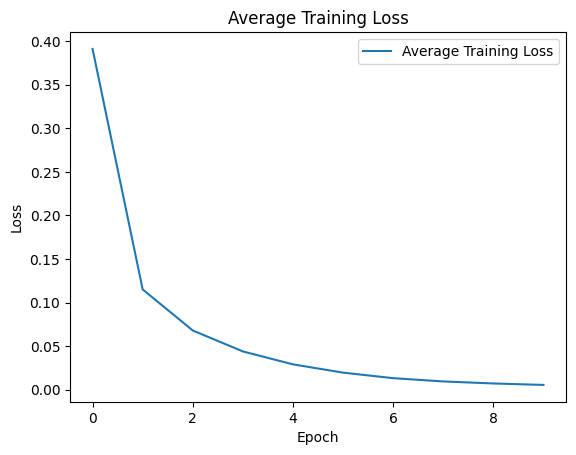

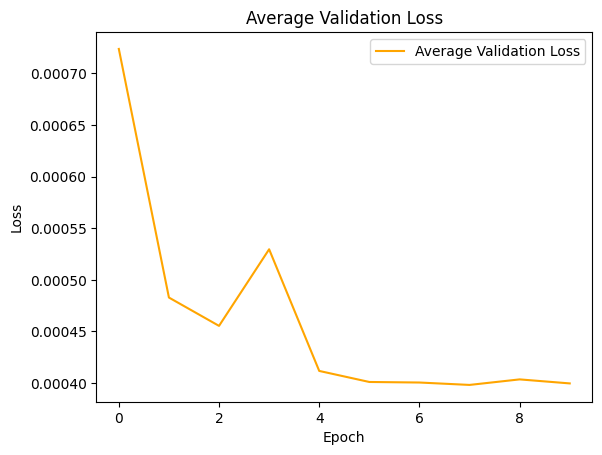

In [53]:
# Plot average training loss
plt.plot(avg_train_losses, label='Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss')
plt.legend()
plt.show()

print("")
print("")

# Plot average validation loss
plt.plot(avg_val_losses, label='Average Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Validation Loss')
plt.legend()
plt.show()

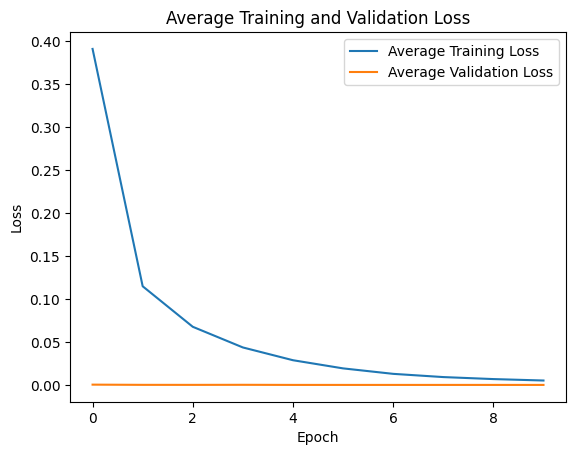

In [54]:
# Visualize training and validation loss
plt.plot(avg_train_losses, label='Average Training Loss')
plt.plot(avg_val_losses, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

In [82]:
!pip install torchprofile
import torchprofile

In [84]:
# Model analysis
# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params)

# Calculate FLOPs
flops = torchprofile.profile_macs(model, (torch.randn(1, 1, 28, 28).to(device),))
print("Number of FLOPs:", flops)


Number of parameters: 535818
Number of FLOPs: 535040


In [85]:
# Generate confusion matrix, precision, and recall scores
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print("Confusion Matrix:")
print(cm)
print("")
print("")
print("Precision:", precision)
print("Recall:", recall)

Confusion Matrix:
[[ 970    1    1    2    0    1    2    2    1    0]
 [   0 1124    3    2    0    1    2    0    3    0]
 [   7    0 1000    2    1    1    1    7   10    3]
 [   0    0    8  982    0    6    0    3    8    3]
 [   3    0    1    0  949    0    5    6    2   16]
 [   2    1    0   12    3  853    5    1   12    3]
 [   8    4    2    0    7    5  926    2    4    0]
 [   0    5   13    2    4    1    0  994    3    6]
 [   4    0    1    7    4    7    4    4  939    4]
 [   2    4    1    6   14    6    2    7    8  959]]


Precision: 0.9693609859432776
Recall: 0.9692081744945247


In [58]:
# Model architecture description
print("Model Architecture:")
print("1. Input Layer: 784 neurons (28x28)")
print("2. Hidden Layer 1: {} neurons, ReLU activation".format(best_params[0]))
print("3. Hidden Layer 2: {} neurons, ReLU activation".format(best_params[1]))
print("4. Output Layer: 10 neurons (corresponding to 10 classes)")

Model Architecture:
1. Input Layer: 784 neurons (28x28)
2. Hidden Layer 1: 512 neurons, ReLU activation
3. Hidden Layer 2: 256 neurons, ReLU activation
4. Output Layer: 10 neurons (corresponding to 10 classes)


# QUESTION 2
CNN Model for MNIST Classification


In [6]:

# Load data from npz file
data = np.load('/content/drive/MyDrive/Datasets/imbalanced_mnist (1).npz')
x_train, y_train = data['X_train'], data['y_train']
x_test, y_test = data['X_test'], data['y_test']

# Normalize the pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to add channel dimension (for CNN)
x_train = np.expand_dims(x_train, axis=1)  # Add channel dimension for grayscale images
x_test = np.expand_dims(x_test, axis=1)

# Convert labels to one-hot encoding
num_classes = 10
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



# Convolutional Layer (Conv1):

Purpose and Functionality: The convolutional layer applies a set of learnable filters to the input image, extracting various features such as edges, textures, and patterns. Each filter slides over the input image, performing element-wise multiplications and summations to produce feature maps.
Contribution to Architecture: Convolutional layers capture local spatial patterns in the input image, helping the model to detect low-level features like edges and gradients.

# ReLU Activation (ReLU1):

Purpose and Functionality: The Rectified Linear Unit (ReLU) activation function introduces non-linearity to the model by replacing negative values with zero, effectively introducing sparsity and allowing the network to learn complex patterns.
Contribution to Architecture: ReLU activation enhances the model's ability to learn and represent non-linear relationships between features.
# Max Pooling Layer (Pool1):

Purpose and Functionality: Max pooling downsamples the feature maps obtained from the convolutional layers, reducing their spatial dimensions while retaining the most salient features. It achieves this by selecting the maximum value within each subregion of the feature map.
Contribution to Architecture: Max pooling helps in reducing computational complexity, making the model more computationally efficient. It also introduces translation invariance by selecting the most relevant features regardless of their exact location within the receptive field.
# Convolutional Layer (Conv2):

Purpose and Functionality: Similar to Conv1, Conv2 applies another set of learnable filters to the feature maps generated by the previous layers, extracting higher-level features that are more complex and abstract.
Contribution to Architecture: Conv2 further refines the representation of features learned in Conv1, enabling the model to capture more abstract and high-level patterns in the input image.
# ReLU Activation (ReLU2):

Purpose and Functionality: ReLU activation is applied again to introduce non-linearity and sparsity, enhancing the model's representation learning capabilities.
Contribution to Architecture: ReLU2 further enriches the feature representation learned by Conv2, allowing the model to learn increasingly complex and abstract features.
# Max Pooling Layer (Pool2):

Purpose and Functionality: Similar to Pool1, Pool2 performs downsampling to further reduce the spatial dimensions of the feature maps while retaining the most important features.
Contribution to Architecture: Pool2 continues the process of reducing computational complexity and introducing translation invariance, preparing the feature maps for the final classification layer.
# Fully Connected Layer (FC):

Purpose and Functionality: The fully connected layer takes the flattened feature maps from the previous layers and maps them to the output classes. Each neuron in this layer is connected to every neuron in the previous layer, allowing for complex combinations of features.
Contribution to Architecture: The FC layer performs the final classification decision based on the learned features from the convolutional layers, providing the model's output predictions for the input image.

In [7]:

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(7*7*32, 10) # 7*7*32 is the size after two max-pooling layers

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 7*7*32)
        x = self.fc(x)
        return x



# Hyperparameter Tuning for CNN Model
To optimize the performance of the CNN model, we perform hyperparameter tuning. This involves adjusting the number of filters in each convolutional layer (num_filters_conv1 and num_filters_conv2) and the learning rate (learning_rate). We explore different combinations of these hyperparameters and evaluate the model's performance on the validation set.

In [10]:
num_epochs=10
criterion = nn.CrossEntropyLoss()

# Hyperparameter Tuning
best_accuracy = 0.0
best_model = None
best_params = None

for num_filters_conv1 in [32, 64]:
    for num_filters_conv2 in [64, 128]:
        for learning_rate in [0.001, 0.01]:
            # Initialize the model and optimizer
            model = CNN()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training loop
            train_losses = []
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, torch.argmax(labels, dim=1))
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                epoch_loss = running_loss / len(train_loader.dataset)
                train_losses.append(epoch_loss)

            # Evaluation on validation set
            model.eval()
            correct = 0
            total = 0
            val_running_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
                    loss = criterion(outputs, torch.argmax(labels, dim=1))
                    val_running_loss += loss.item() * inputs.size(0)
            accuracy = correct / total
            val_epoch_loss = val_running_loss / len(test_loader.dataset)

            print(f"Filters in Conv1: {num_filters_conv1}, Filters in Conv2: {num_filters_conv2}, Learning Rate: {learning_rate}")
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_params = (num_filters_conv1, num_filters_conv2, learning_rate)

print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best Hyperparameters: Filters in Conv1: {best_params[0]}, Filters in Conv2: {best_params[1]}, Learning Rate: {best_params[2]}")



Filters in Conv1: 32, Filters in Conv2: 64, Learning Rate: 0.001
Epoch 10/10, Train Loss: 0.0159, Validation Loss: 0.0407, Accuracy: 0.9876
Filters in Conv1: 32, Filters in Conv2: 64, Learning Rate: 0.01
Epoch 10/10, Train Loss: 0.0616, Validation Loss: 0.0833, Accuracy: 0.9770
Filters in Conv1: 32, Filters in Conv2: 128, Learning Rate: 0.001
Epoch 10/10, Train Loss: 0.0159, Validation Loss: 0.0422, Accuracy: 0.9873
Filters in Conv1: 32, Filters in Conv2: 128, Learning Rate: 0.01
Epoch 10/10, Train Loss: 0.0712, Validation Loss: 0.0787, Accuracy: 0.9755
Filters in Conv1: 64, Filters in Conv2: 64, Learning Rate: 0.001
Epoch 10/10, Train Loss: 0.0137, Validation Loss: 0.0391, Accuracy: 0.9888
Filters in Conv1: 64, Filters in Conv2: 64, Learning Rate: 0.01
Epoch 10/10, Train Loss: 0.0499, Validation Loss: 0.0807, Accuracy: 0.9811
Filters in Conv1: 64, Filters in Conv2: 128, Learning Rate: 0.001
Epoch 10/10, Train Loss: 0.0152, Validation Loss: 0.0377, Accuracy: 0.9890
Filters in Conv1: 64

In [12]:
# Evaluation on test set using the best model
best_model.eval()
predictions = []
targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        targets.extend(torch.argmax(labels, dim=1).tolist())

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(targets, predictions)
precision = precision_score(targets, predictions, average='macro')
recall = recall_score(targets, predictions, average='macro')

print(f"Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Test Set Performance:
Accuracy: 0.9890, Precision: 0.9890, Recall: 0.9889


In [15]:
# Calculate number of trainable parameters
num_trainable_params_cnn = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
print("Number of Trainable Parameters for CNN model:", num_trainable_params_cnn)

# Assuming input size of 28x28
input_size = (1, 28, 28)  # (channels, height, width)

# Create a tensor on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flops_cnn = torch.randn(1, *input_size).to(device)

# Move the model to the same device as the input tensor
model.to(device)

# Calculate FLOPs
with torch.cuda.device(device):
    flops_cnn = model.forward(flops_cnn)
    flops_cnn = flops_cnn * 2 * sum(p.numel() for p in model.parameters() if p.requires_grad)  # Multiply by 2 for both multiply and addition operations

# Print the FLOPs
print("FLOPs for CNN model:", flops_cnn)

Number of Trainable Parameters for CNN model: 20490
FLOPs for CNN model: tensor([[ 20675.0723,  64414.8320,  19171.0664, -26228.9609, -16800.5195,
           2365.7346, -23940.9180,  13288.8047, -24473.7930,  -9657.2646]],
       device='cuda:0', grad_fn=<MulBackward0>)


# Performance Metrics:

**Accuracy:**  The accuracy obtained from the FFNN model is 96.96%, while the accuracy of the CNN model is 98.90%. The CNN model achieves a higher accuracy, indicating superior performance in overall classification accuracy.
**Precision and Recall:** The precision and recall scores for the FFNN model are approximately 96.94% and 96.92%, respectively. In comparison, the precision and recall scores for the CNN model are both approximately 98.90%. The CNN model demonstrates higher precision and recall values, indicating better performance in correctly identifying positive cases and minimizing false positives.
Number of Trainable Parameters:

**FFNN Model:** The FFNN model has 535,818 trainable parameters.
**CNN Model: **The CNN model has 20,490 trainable parameters. The CNN model has significantly fewer trainable parameters, suggesting a more efficient utilization of parameters.
